In [6]:
import gym
import numpy as np
from IPython.display import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_mean_rewards(rewards, transitions, policy):
    return (rewards * transitions * policy[:,:,np.newaxis]).sum(axis = (1,2))

In [3]:
def get_mean_transitions(rewards, transitions, policy):
    return (transitions * policy[:,:,np.newaxis]).sum(axis = (1))

In [4]:
def evaluate_value_func(rewards, transitions, policy, gamma, max_iter, tolerance):
    # transitions - [s, a, s']
    # rewards - [s, a, s']
    # policy  - [s, a]
    mean_rewards = get_mean_rewards(rewards, transitions, policy)
    mean_transitions = get_mean_transitions(rewards, transitions, policy)
    #v = np.random.normal(size=rewards.shape[0])
    v = np.zeros(rewards.shape[0]) 
    for k in range(max_iter):
        old_v = np.copy(v)
        v = mean_rewards + gamma * mean_transitions.dot(v)
        #print(mean_rewards)
        if np.abs(old_v - v).max() < tolerance:
            print('last k ', k)
            break
    return v

In [5]:
def get_params(env, ns, na):
    transitions = np.zeros([ns, na, ns])
    rewards = np.zeros([ns, na, ns])
    for s in range(ns):
        for a in range(na):
            current_transitions = env.P[s][a]
            for p_trans,  next_s,rew, done in current_transitions:
                transitions[s,a,next_s] += p_trans
                rewards[s,a,next_s] = rew
            transitions[s,a,:]/=np.sum(transitions[s,a,:])
    return rewards, transitions

In [6]:
def do_policy_iteration(rewards, transitions, gamma = 1, 
                        max_iter_eval = 100, max_iter_update = 1000, tolerance = 10e-8):
    ns = rewards.shape[0]
    na = rewards.shape[1]
    policy = np.zeros((ns, na))
    
    for i in range(max_iter_update):
        v = evaluate_value_func(rewards, transitions, policy, gamma, max_iter_eval, tolerance) 
        q = (transitions * (rewards + gamma * v[np.newaxis, np.newaxis, :]) ).sum(axis = 2)
       
        new_policy = np.zeros_like(policy)
        new_policy[np.arange(ns), np.argmax(q, axis = 1)] = 1
        
        if np.array_equal(policy, new_policy):
            break
        policy = np.copy(new_policy)
        
    return policy

In [172]:
name = 'FrozenLake8x8-v0'
env = gym.make(name)
env.reset()

[2017-06-27 12:44:41,947] Making new env: FrozenLake8x8-v0


0

In [173]:
ns = env.observation_space.n
na = env.action_space.n
rewards, transitions = get_params(env, ns, na)

In [174]:
fixed_policy = do_policy_iteration(rewards, transitions)
gamma = 1

('last k ', 0)
('last k ', 29)


In [175]:
real_values = evaluate_value_func(rewards, transitions, fixed_policy, gamma, 1000, 10e-8)

('last k ', 747)


In [176]:
def rmse(y_true, y_predict):
    return np.sqrt(((y_true - y_predict) ** 2).mean())

In [209]:
def mc_with_simple_mean(env, policy, count_rmse, outer_loop = 10, n_episodes = 1000):
    estimates = np.zeros(ns)
    
    for j in range(outer_loop):
        counts = np.zeros(ns)
        sums = np.zeros(ns)
        history = np.zeros(n_episodes)
        for i in range(n_episodes):
            seen = np.zeros(ns)
            observation = env.reset()
            episode_reward = 0
            ######
            while True:
                action = policy[observation].argmax()
                observation, reward, done, info = env.step(action)

                if not seen[observation]:
                    seen[observation] = 1
                    counts[observation] += 1

                for obs in range(ns):
                    if seen[obs]:
                        sums[obs] += reward

                if done:
                    break
            ######
            counts[counts == 0] = 1
            history[i] = count_rmse(sums / counts)
            
        counts[counts == 0] = 1
        estimates +=  sums / counts
    return estimates / outer_loop, history

In [178]:
def mc_with_running_mean(env, policy, count_rmse, alpha_coef = 1, n_episodes = 1000):
    estimates = np.zeros(ns)
    
    history = np.zeros(n_episodes)
    for i in range(n_episodes):
        sums = np.zeros(ns)
        seen = np.zeros(ns)
        observation = env.reset()
        episode_reward = 0
        while True:                
            action = policy[observation].argmax()
            observation, reward, done, info = env.step(action)

            if not seen[observation]:
                seen[observation] = 1
                sums[observation]  = -1 * episode_reward

            for obs in range(ns):
                if seen[obs]:
                    sums[obs] += reward

            episode_reward += reward
            if done:
                break

        estimates +=  alpha_coef * (sums - estimates)
        history[i] = count_rmse(estimates)
        
    return estimates, history

In [179]:
def simple_td(env, policy, count_rmse, alpha_coef, gamma = 1, n_episodes = 1000):
    ns, na = policy.shape
    estimates = np.random.normal(size = ns, scale = 0.01)
    history = np.zeros(n_episodes)
    for i in range(n_episodes):
        observation = env.reset()
        ##########
        while True:
            action = policy[observation].argmax()
            new_observation, reward, done, info = env.step(action)
            estimates[observation]+= alpha_coef * (reward + \
                                                   gamma * estimates[new_observation] - estimates[observation]) 
            observation = new_observation
            
            if done:
                break
        ##########
        history[i] = count_rmse(estimates)
    return estimates, history

In [259]:
def td(env, policy, count_rmse, alpha_coef = 1, lambda_coef = 0, gamma = 1, n_episodes = 1000, online = True):
    ns, na = policy.shape
    estimates = np.random.normal(size = ns, scale = 0.01) 
    history = np.zeros(n_episodes)
    
    for i in range(n_episodes):
        traces = np.zeros(ns)
        observation = env.reset()
        
        if not online:
            changes = np.zeros(ns)
            
        ##########
        while True:
            traces[observation] += 1
            
            action = policy[observation].argmax()
            new_observation, reward, done, info = env.step(action)
            sigma = reward + gamma * estimates[new_observation] - estimates[observation]
            
            if online:
                estimates[observation]  += alpha_coef * sigma * traces[observation]
            else:
                changes[observation] += alpha_coef * sigma * traces[observation]
            
            traces *= gamma * lambda_coef
            observation = new_observation
            
            if done:
                break
        ##########
                
        if not online:
            estimates += changes
            
        history[i] = count_rmse(estimates)
            
    return estimates, history

In [193]:
rmse(real_values, simple_mc_values)

0.13234125777968198

### Графики

In [213]:
simple_mc_values, simple_mc_history = mc_with_simple_mean(env, fixed_policy, lambda x: rmse(real_values, x),
                                       outer_loop = 1, n_episodes = 2500)

In [232]:
mc_values, mc_history = mc_with_running_mean(env, fixed_policy, lambda x: rmse(real_values, x),
                           alpha_coef = 0.005,  n_episodes = 2500)

In [253]:
simple_td_values, simple_td_history = td(env, fixed_policy, lambda x: rmse(real_values, x),
                           alpha_coef = 0.4, lambda_coef = 0, n_episodes = 2500)

In [288]:
likemc_td_values, likemc_td_history = td(env, fixed_policy, lambda x: rmse(real_values, x),
                           alpha_coef = 0.005, lambda_coef = 1, n_episodes = 2500, online = False)

In [281]:
td_values, td_history = td(env, fixed_policy, lambda x: rmse(real_values, x),
                           alpha_coef = 0.5, lambda_coef = 0.5, n_episodes = 2500, online = True)

In [212]:
simple_mc_history.shape

(3000,)

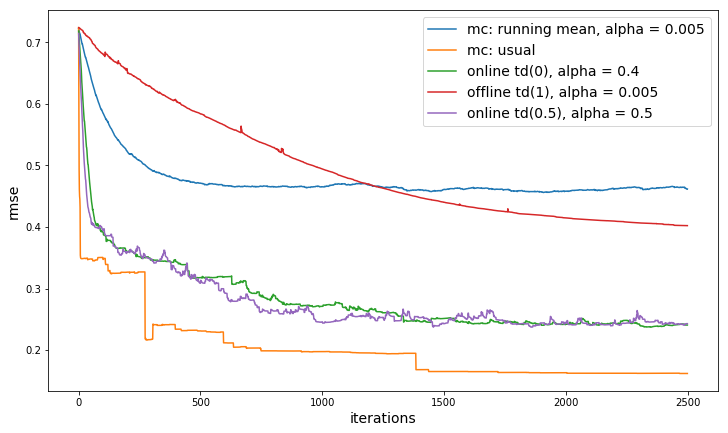

In [289]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(mc_history.shape[0]), mc_history, label = 'mc: running mean, alpha = 0.005')
plt.plot(np.arange(simple_mc_history.shape[0]), simple_mc_history, label = 'mc: usual')
plt.plot(np.arange(simple_td_history.shape[0]), simple_td_history, label = 'online td(0), alpha = 0.4')
plt.plot(np.arange(likemc_td_history.shape[0]), likemc_td_history, label = 'offline td(1), alpha = 0.005')
plt.plot(np.arange(td_history.shape[0]), td_history, label = 'online td(0.5), alpha = 0.5')

#plt.plot(np.arange(td_history.shape[0]), td_history, label = 'offline td(1)')
#plt.plot(np.arange(simple_mc_history.shape[0]), simple_mc_history, label = 'simple mc')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('iterations', fontsize=14)
plt.ylabel('rmse', fontsize=14)

## Model free control

In [31]:
def check_solution(env, policy, n_episodes = 100, max_steps = 100, to_wrap = False, to_send = False, name2save = ''):
    ns = env.observation_space.n
    na = env.action_space.n
    count_dones = np.zeros(n_episodes)
    count_steps = np.zeros(n_episodes)
    if to_wrap:
        env = wrappers.Monitor(env, name2save)
        
    for i in range(n_episodes):
        observation = env.reset() 
        for step in range(max_steps): 
            action = policy[observation].argmax()
            observation, reward, done, info = env.step(action)
            count_dones[i] += reward
            count_steps[i] += 1
            if done:
                break
    return np.mean(count_dones)
    #print(np.mean(count_steps))
    env.close()
    if to_wrap and to_send:
        gym.upload(name2save, api_key='sk_bExD4VfCSQukGlQkYKBhdQ')

## On-Policy MC

In [28]:
from collections import defaultdict

def on_policy_mc(env, eps = 1, eps_decay = 0.995, gamma = 1, kappa = 0.01, n_episode = 1000):
    eps = 1.0 * eps
    
    ns = env.observation_space.n
    na = env.action_space.n
    Q = np.zeros((ns, na))
    
    ### starting random policy
    policy = eps * np.ones((ns, na)) / na
    max_ind = np.random.choice(np.arange(na), size = ns)
    policy[np.arange(ns), max_ind] = 1 + eps / na - eps
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    avg_reward = None

    for i in range(n_episode):
        if i % 10000 == 0:
            print(i)
        history = []
        s = env.reset()
        step = 0 
        ##########
        while True:
            a = np.random.choice(na, 1, p = policy[s])[0]
            new_s, reward, done, info = env.step(a)
            history.append((s, a, reward))
            s = new_s
            step += 1
            if done:
                # Running average of the terminal reward, which is used for controlling an exploration rate
                # (This idea of controlling exploration rate by the terminal reward is suggested by JKCooper2)
                # See https://gym.openai.com/evaluations/eval_xSOlwrBsQDqUW7y6lJOevQ
                if avg_reward == None:
                    avg_reward = reward
                else:
                    avg_reward = kappa * reward + (1 - kappa) * avg_reward
                if reward > avg_reward:
                    # Bias the current policy toward exploitation
                    eps *= eps_decay
            if done:
                break
        ##########
        sa_in_episode = set([(x[0], x[1]) for x in history])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i,x in enumerate(history)
                                       if x[0] == state and x[1] == action)
            
            G = sum([x[2] * (gamma ** i) for i,x in enumerate(history[first_occurence_idx:])])
            
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        policy = eps * np.ones((ns, na)) / na
        best_actions = Q.argmax(axis = 1)
        policy[np.arange(ns), best_actions] = 1 + eps / na - eps
    
    policy = np.zeros((ns, na))
    policy[np.arange(ns), Q.argmax(axis=1)] = 1
    return Q

In [26]:
name = 'FrozenLake-v0'
env = gym.make(name)

[2017-07-03 16:40:08,817] Making new env: FrozenLake-v0


In [48]:
%%time
mc_policy = on_policy_mc(env, n_episode = 30000)

0
10000
20000
CPU times: user 32.1 s, sys: 4 ms, total: 32.1 s
Wall time: 32.1 s


In [55]:
check_solution(env, mc_policy, n_episodes = 1000, max_steps = 250,
              name2save = 'sarsa')

0.49099999999999999

In [3]:
def find_terminal_states(env):
    ns = env.observation_space.n
    na = env.action_space.n
    
    terminal_states = np.zeros(ns)
    
    for s in range(ns):
        for a in range(na):
            current_transitions = env.P[s][a]
            for p_trans,  next_s, rew, done in current_transitions:
                if done:
                    terminal_states[next_s] = 1
    return terminal_states

In [144]:
find_terminal_states(env)

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  1.])

In [4]:
def get_eps_greedy_policy(Q, eps):
    ns, na = Q.shape
    policy = eps * np.ones((ns, na)) / na
    best_actions = Q.argmax(axis = 1)
    policy[np.arange(ns), best_actions] = 1 + eps / na - eps
    return policy

In [143]:
def select_a_with_epsilon_greedy(curr_s, q_value, epsilon=0.1):
    a = np.argmax(q_value[curr_s, :])
    if np.random.rand() < epsilon:
        a = np.random.randint(q_value.shape[1])
    return a

## Sarsa

In [365]:
def sarsa(env, n_episodes = 1, eps = 1.0, eps_decay = 0.999,
          gamma = 0.99, alpha = 0.1, kappa = 0.01, max_steps = 100, print_options = True):
    eps *= 1.0
    alpha *= 1.0
    
    ns = env.observation_space.n
    na = env.action_space.n

    terminal_states = find_terminal_states(env)
    Q = np.zeros((ns, na))
    
    policy = get_eps_greedy_policy(Q, eps)
    
    avg_reward = None

    for i in range(n_episodes):
        if i % 1000 == 0 and print_options:
            print(i)
        s = env.reset()
        a = np.random.choice(na, 1, p = policy[s])[0]
        for step in range(max_steps):
            new_s, reward, done, info = env.step(a)
            #new_a = np.random.choice(na, 1, p = policy[new_s])[0]
            new_a = select_a_with_epsilon_greedy(new_s, Q, epsilon = eps)
            
            if done:
                # Running average of the terminal reward, which is used for controlling an exploration rate
                # (This idea of controlling exploration rate by the terminal reward is suggested by JKCooper2)
                # See https://gym.openai.com/evaluations/eval_xSOlwrBsQDqUW7y6lJOevQ
                kappa = 0.01
                if avg_reward == None:
                    avg_reward = reward
                else:
                    avg_reward = kappa * reward + (1 - kappa) * avg_reward
                if reward > avg_reward:
                    # Bias the current policy toward exploitation
                    eps *= eps_decay
                    
            Q[s][a] += alpha  * (reward + gamma * Q[new_s][new_a] - Q[s][a])
            s = new_s
            a = new_a
            #eps *= eps_decay
            policy = get_eps_greedy_policy(Q, eps)
            if done:
                break
    return get_eps_greedy_policy(Q, 0.0)

In [388]:
import itertools
def find_sarsa_hyperparams(env):
    alphas = [0.01, 0.1, 0.5]
    eps = [0.5, 0.7, 1.0]
    kappas = [0.001, 0.01, 0.1]
    n_episodes = [20000]
    eps_decays = [1.0, 0.995]
    
    best_score = 0
    history = []
    for (alpha, eps,eps_decay, kappa, n) in tqdm(itertools.product(alphas, eps, eps_decays, kappas, n_episodes)):
        #print(i)
        policy = sarsa(env, n_episodes = n, eps = eps, eps_decay = eps_decay,  alpha = alpha, kappa = kappa,
                      print_options = False)
        score = check_solution(env,policy, n_episodes=250)
        history.append((alpha, eps,eps_decay, kappa, n, score))
        if score > best_score:
            print("best score params:", alpha, eps,eps_decay, kappa, n)
            best_score = score
    return history

#### Подбор гиперпараметров

In [389]:
history = find_sarsa_hyperparams(env)

7it [03:07, 25.77s/it]

('best score params:', 0.01, 0.7, 1.0, 0.001, 20000)


28it [11:08, 25.69s/it]

('best score params:', 0.1, 0.7, 0.995, 0.001, 20000)


29it [11:42, 28.19s/it]

('best score params:', 0.1, 0.7, 0.995, 0.01, 20000)


54it [21:08, 20.06s/it]


In [390]:
np.random.seed(42)
policy_best = sarsa(env, n_episodes = 20000, eps = 0.7, eps_decay = 0.995,  alpha = 0.1, kappa = 0.01)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


#### Проверка и загрузка FrozenLake8x8-v0

In [326]:
name = 'FrozenLake8x8-v0'
env = gym.make(name)

[2017-06-30 16:50:43,426] Making new env: FrozenLake8x8-v0


In [354]:
check_solution(env, policy_star_0, n_episodes = 1000, max_steps = 250, to_wrap = True, to_send = True, 
              name2save = 'sarsa')

[2017-06-30 17:02:58,587] Attempted to wrap env <FrozenLakeEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-06-30 17:02:58,592] Creating monitor directory sarsa
[2017-06-30 17:02:58,597] Starting new video recorder writing to /home/liza/Документы/Python-projects/RL/sarsa/openaigym.video.0.2888.video000000.json
[2017-06-30 17:02:58,618] Starting new video recorder writing to /home/liza/Документы/Python-projects/RL/sarsa/openaigym.video.0.2888.video000001.json
[2017-06-30 17:02:58,653] Starting new video recorder writing to /home/liza/Документы/Python-projects/RL/sarsa/openaigym.video.0.2888.video000008.json
[2017-06-30 17:02:58,706] Starting new video recorder writing to /home/liza/Документы/Python-projects/RL/sarsa/openaigym.video.0.2888.video000027.json
[2017-06-30 17:02:58,777] Starting new video recorder writing to /home/liza/Документы/Python-projects/RL/sarsa/openaigym.video.0.2888.video000064.json
[2017-06-30 17:02:58,857]

0.84
82.719


[2017-06-30 17:03:02,759] [FrozenLake8x8-v0] Uploading videos of 10 training episodes (3058 bytes)
[2017-06-30 17:03:03,362] [FrozenLake8x8-v0] Creating evaluation object from sarsa with learning curve and training video
[2017-06-30 17:03:03,977] 
****************************************************
You successfully uploaded your evaluation on FrozenLake8x8-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_n8gWOgQD60qADd9H3LA

****************************************************
